In [1]:
import torch
import numpy as np
import cv2
import PIL

print(torch.__version__)
print(np.__version__)
print(cv2.__version__)
print(PIL.__version__)

2.10.0+cu128
2.4.2
4.13.0
12.1.0


In [2]:
import os
import shutil
import scipy.io as sio
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import cv2
import torch.nn.functional as F

import xml.etree.ElementTree as ET
from PIL import Image, ImageFile

ImageFile.LOAD_TRUNCATED_IMAGES = True

### **(1) 데이터셋 준비하기**

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [4]:
# 원본 데이터 경로 (압축 해제 후 폴더)
images_dir = os.path.join(os.getenv("HOME"), 'work/class_activation_map/Images')   # 이미지들이 위치한 폴더
mat_dir = os.path.join(os.getenv("HOME"), 'work/class_activation_map')   # 프로젝트 루트 디렉토리

# .mat 파일 경로 (train_list.mat와 test_list.mat가 각각 같은 구조라고 가정)
train_mat_path = os.path.join(mat_dir, 'train_list.mat')
test_mat_path = os.path.join(mat_dir, 'test_list.mat')

# .mat 파일 로드
train_mat = sio.loadmat(train_mat_path)
test_mat = sio.loadmat(test_mat_path)

# train_mat와 test_mat 내부에 'file_list'와 'labels' 등이 있음
train_file_list = train_mat['file_list']
train_labels = train_mat['labels'].squeeze()  # (N,)
test_file_list = test_mat['file_list']
test_labels = test_mat['labels'].squeeze()

# 최종적으로 ImageFolder 구조로 재구성할 대상 폴더 생성 (예: stanford_dogs/train, stanford_dogs/test)
base_dir = 'stanford_dogs'
train_dir = os.path.join(base_dir, 'train')
test_dir = os.path.join(base_dir, 'test')

os.makedirs(train_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

def process_mat_file(file_list_array, split_dir):
    """
    .mat 파일에서 로드한 file_list_array를 사용해,
    split_dir(예: train 혹은 test)에 클래스별 폴더를 생성하고 이미지를 복사합니다.
    """
    num_files = file_list_array.shape[0]
    for idx in range(num_files):
        # file_list_array[idx]는 보통 array([<파일경로>]) 형태입니다.
        # 따라서, array([<파일경로>]).item()을 사용하면 실제 문자열을 얻을 수 있습니다.
        file_path = file_list_array[idx][0].item()

        # 혹시 bytes 타입이면 문자열로 디코딩
        if isinstance(file_path, bytes):
            file_path = file_path.decode('utf-8')

        # 파일 경로 예시: 'n02116738-African_hunting_dog/n02116738_2988.jpg'
        # 클래스 이름은 파일 경로의 최상위 폴더명 (예: 'n02116738-African_hunting_dog')
        class_folder = file_path.split('/')[0]

        # 대상 클래스 폴더 생성
        dest_folder = os.path.join(split_dir, class_folder)
        os.makedirs(dest_folder, exist_ok=True)

        # 원본 이미지 경로: Images 폴더 아래에 file_path 위치
        src_path = os.path.join(images_dir, file_path)
        # 대상 이미지 경로: dest_folder 아래에 원본 파일명 그대로 복사
        dest_path = os.path.join(dest_folder, os.path.basename(file_path))

        # 파일 존재 여부 확인 후 복사
        if os.path.exists(src_path):
            shutil.copy(src_path, dest_path)
        else:
            print(f"File not found: {src_path}")

print("Processing train set...")
process_mat_file(train_file_list, train_dir)
print("Processing test set...")
process_mat_file(test_file_list, test_dir)

print("Dataset reorganization complete.")

Processing train set...
Processing test set...
Dataset reorganization complete.


In [5]:
class StanfordDogsDatasetWithBBox(datasets.ImageFolder):
    def __init__(self, root, annotation_root, transform=None):
        super().__init__(root, transform=transform)
        self.annotation_root = annotation_root  # 예: '/content/Annotation'
        self.new_size = (224, 224)

    def __getitem__(self, index):
        image, label = super().__getitem__(index)
        path, _ = self.samples[index]

        rel_path = os.path.relpath(path, self.root)
        annot_filename = os.path.splitext(os.path.basename(rel_path))[0]
        annot_folder = os.path.dirname(rel_path)
        annot_path = os.path.join(self.annotation_root, annot_folder, annot_filename)

        # bbox 기본값 (예: [ymin, xmin, ymax, xmax])
        bbox = [0.0, 0.0, 0.0, 0.0]

        if os.path.exists(annot_path):
            try:
                # 확장자가 없지만 XML 형식의 파일이라고 가정하고 파싱
                tree = ET.parse(annot_path)
                root_xml = tree.getroot()
                # 첫 번째 object 태그에서 bndbox 정보를 읽음
                obj = root_xml.find('object')
                if obj is not None:
                    bndbox = obj.find('bndbox')
                    if bndbox is not None:
                        xmin = float(bndbox.find('xmin').text)
                        ymin = float(bndbox.find('ymin').text)
                        xmax = float(bndbox.find('xmax').text)
                        ymax = float(bndbox.find('ymax').text)
                        # XML 내 <size> 태그에서 원본 이미지 크기 획득
                        size = root_xml.find('size')
                        w = float(size.find('width').text)
                        h = float(size.find('height').text)
                        new_h, new_w = self.new_size
                        # bbox 좌표 순서: [ymin, xmin, ymax, xmax]
                        bbox = [xmin * (new_w / w), ymin * (new_h / h),
                                xmax * (new_w / w), ymax * (new_h / h)]
                    else:
                        print(f"bndbox 태그를 찾을 수 없습니다: {annot_path}")
                else:
                    print(f"object 태그를 찾을 수 없습니다: {annot_path}")
            except Exception as e:
                print(f"Error parsing {annot_path}: {e}")
        else:
            print(f"Annotation file not found: {annot_path}")

        return image, label, bbox

In [6]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# 데이터셋 경로 (재구성한 ImageFolder 형식)
train_dir = os.path.join('stanford_dogs', 'train')
test_dir = os.path.join('stanford_dogs', 'test')
# Annotation 폴더 경로 (예: '/root/Annotation')
annotation_dir = os.path.join(os.getenv("HOME"), 'work/class_activation_map/Annotation')

# 커스텀 데이터셋 생성: image, label, bbox 반환
train_dataset = StanfordDogsDatasetWithBBox(root=train_dir, annotation_root=annotation_dir, transform=transform)
valid_dataset = StanfordDogsDatasetWithBBox(root=test_dir, annotation_root=annotation_dir, transform=transform)

batch_size = 12
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

num_classes = len(train_dataset.classes)
print(f"Number of classes: {num_classes}")
print(f"Train samples: {len(train_dataset)}")
print(f"Test samples: {len(valid_dataset)}")

Number of classes: 120
Train samples: 12000
Test samples: 8580


In [7]:
def visualize(sample):
    img_tensor, label, bbox = sample

    # 인덱스와 클래스 정보
    print("Label index:", label)
    print("Class name:", train_dataset.classes[label])

    # 정규화 복원 전처리 시 사용한 평균과 표준편차
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])

    # tensor의 shape: (C, H, W) -> (H, W, C)
    img_np = img_tensor.permute(1, 2, 0).numpy()
    img_np = std * img_np + mean
    img_np = np.clip(img_np, 0, 1)

    plt.figure(figsize=(6,6))
    plt.imshow(img_np)
    plt.title(f"Class: {train_dataset.classes[label]}")
    plt.axis('off')
    plt.show()

Label index: 0
Class name: n02085620-Chihuahua


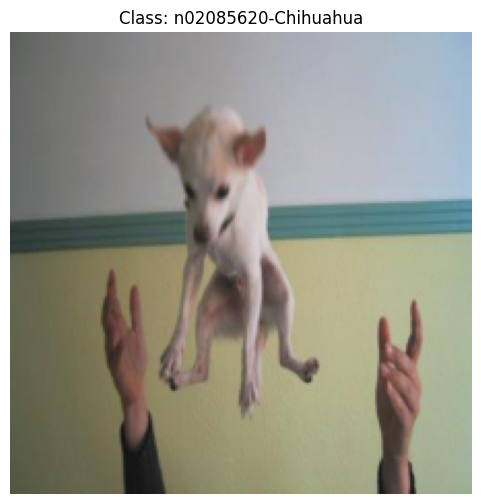

In [8]:
# 임의의 한 샘플 선택 (여기서는 첫 번째 샘플을 사용)
train_sample = train_dataset[0]

visualize(train_sample)

### **(2) 물체의 위치정보**

In [9]:
# Annotation 폴더에서 데이터를 골라보세요
annotation_path = os.path.join(os.getenv("HOME"), 'work/class_activation_map/Annotation/n02085620-Chihuahua/n02085620_10074')


# XML 파일 파싱
tree = ET.parse(annotation_path)
root = tree.getroot()

for elem in root.iter():
    print(f"{elem.tag}: {elem.text}")

annotation: 
	
folder: 02085620
filename: n02085620_10074
source: 
		
database: ImageNet database
size: 
		
width: 333
height: 500
depth: 3
segment: 0
object: 
		
name: Chihuahua
pose: Unspecified
truncated: 0
difficult: 0
bndbox: 
			
xmin: 25
ymin: 10
xmax: 276
ymax: 498


## **CAM 구현하기**

### **CAM 모델 만들기**

In [10]:
model = models.resnet50(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, len(train_dataset.classes))
model = model.to(device)

/home/jjeong3150/anaconda3/envs/aiffel_learning_py312/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/jjeong3150/anaconda3/envs/aiffel_learning_py312/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [11]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

In [12]:
def train_model(model, save_name, train_loader, valid_loader, criterion, optimizer, num_epochs=10, patience=3):
    
    best_test_acc = 0
    patience_counter = 0
    
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        print(f"\nEpoch {epoch+1}/{num_epochs} 시작")
        for batch_idx, (images, labels, _) in enumerate(train_loader):
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (preds == labels).sum().item()
            if (batch_idx + 1) % 200 == 0:
                print(f"  Step {batch_idx+1} - Loss: {loss.item():.4f}")

        train_loss = running_loss / (batch_idx + 1)
        train_acc = correct / total
        print(f"Train - Loss: {train_loss:.4f}, Accuracy: {train_acc*100:.2f}%")

        # 검증 단계
        model.eval()
        running_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for images, labels, _ in valid_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                running_loss += loss.item()
                _, preds = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (preds == labels).sum().item()
        test_loss = running_loss / len(valid_loader)
        test_acc = correct / total
        print(f"Validation - Loss: {test_loss:.4f}, Accuracy: {test_acc*100:.2f}%")

        # -------------------------
        # ⭐ Early Stopping 체크
        # -------------------------
        if test_acc > best_test_acc:
            best_test_acc = test_acc
            patience_counter = 0

            # best 모델 저장
            # torch.save(model.state_dict(), f"{save_name}")
            torch.save(model, f"{save_name}")
            print("✔ Best model 저장됨")

        else:
            patience_counter += 1
            print(f"개선 없음 ({patience_counter}/{patience})")

            if patience_counter >= patience:
                print("\n🚨 Early Stopping: validation accuracy 개선 없음")
                break

In [13]:
%%time
save_name = "cam_model_2.pt"
train_model(model, save_name, train_loader, valid_loader, criterion, optimizer, num_epochs=100, patience=3)


Epoch 1/100 시작
  Step 200 - Loss: 4.0790
  Step 400 - Loss: 3.5131
  Step 600 - Loss: 3.3057
  Step 800 - Loss: 3.0984
  Step 1000 - Loss: 2.3147
Train - Loss: 3.2532, Accuracy: 21.36%
Validation - Loss: 3.1449, Accuracy: 25.24%
✔ Best model 저장됨

Epoch 2/100 시작
  Step 200 - Loss: 1.2939
  Step 400 - Loss: 1.7831
  Step 600 - Loss: 2.5431
  Step 800 - Loss: 1.6830
  Step 1000 - Loss: 2.3083
Train - Loss: 2.2202, Accuracy: 38.73%
Validation - Loss: 2.2656, Accuracy: 41.56%
✔ Best model 저장됨

Epoch 3/100 시작
  Step 200 - Loss: 2.1932
  Step 400 - Loss: 1.2396
  Step 600 - Loss: 1.6406
  Step 800 - Loss: 2.6561
  Step 1000 - Loss: 1.1959
Train - Loss: 1.7517, Accuracy: 50.15%
Validation - Loss: 2.6238, Accuracy: 35.20%
개선 없음 (1/3)

Epoch 4/100 시작
  Step 200 - Loss: 1.6644
  Step 400 - Loss: 0.6242
  Step 600 - Loss: 2.0142
  Step 800 - Loss: 0.7198
  Step 1000 - Loss: 2.1219
Train - Loss: 1.4159, Accuracy: 57.55%
Validation - Loss: 1.9731, Accuracy: 48.04%
✔ Best model 저장됨

Epoch 5/100 시작
 

In [14]:
# cam_model_3.pt
save_name = "cam_model_2.pt"
cam_model_path = os.path.join(os.getenv("HOME"), f"work/class_activation_map/{save_name}")

# torch.save(model, cam_model_path)

In [15]:
def unnormalize(img_tensor):
    """
    img_tensor: [C, H, W] 텐서 (전처리 상태, 예: normalization 적용됨)
    ImageNet 평균 및 표준편차를 이용하여 복원 (RGB 순서)
    """
    mean = np.array([0.485, 0.456, 0.406])
    std  = np.array([0.229, 0.224, 0.225])
    img = img_tensor.cpu().numpy().transpose(1, 2, 0)
    img = std * img + mean
    img = np.clip(img, 0, 1)
    img = np.uint8(255 * img)
    return img

In [16]:
# 원하는 데이터를 골라서 진행해보세요

image, label, bbox = train_dataset[0]
sample_image = image.unsqueeze(0).to(device)

In [17]:
import os

# cam_model_path = os.path.join(os.getenv("HOME"), "work/class_activation_map/cam_model.pt")
model = torch.load(cam_model_path, weights_only=False)

In [18]:
def generate_cam(model, image):
    # 모델을 평가 모드로 전환
    model.eval()

    # forward hook으로 뽑아낼 feature map을 저장할 리스트 정의
    features = []

    # Hook(중간 feature 저장) 등록
    def hook(module, input, output):
        features.append(output.detach())
        # output.detach() : Autograd 그래프에서 분리해서 gradient 추적을 끊음
        # CAM은 보통 gradient가 필요 없고(Grad-CAM이 필요), 메모리도 절약
        # features.append() : hook이 불릴 때마다 feature map을 리스트에 저장

    # model.layer4에 forward hook을 단다
    hook_handle = model.layer4.register_forward_hook(hook)

    # 순전파 실행 + hook 해제
    # 모델에 이미지를 넣어 클래스 로짓(logits)을 얻음
    # 동시에 방금 hook을 걸어놨기 때문에, model.layer4의 출력이 features 리스트에 저장됨
    output = model(image)
    
    # hook을 제거
    # 안 지우면 다음 forward 때도 계속 쌓이거나(메모리 증가), 다른 코드에 영향 줌
    hook_handle.remove()


    # 예측된 클래스 선택 (배치의 첫 번째 이미지 기준)
    pred_class = output.argmax(dim=1).item()
    # argmax(dim=1): 각 배치 샘플마다 가장 큰 점수의 클래스를 선택
    # .item(): 파이썬 정수로 변환

    # 모델의 fc layer 가중치가 모델과 동일한 디바이스에 있도록 처리
    fc_weights = model.fc.weight.data.to(image.device)
    # model.fc.weight: 각 클래스마다 feature 채널에 대한 가중치 벡터
    # .data: 텐서 값만 가져오겠다는 의미
    # .to(image.device): 입력 이미지가 GPU면 가중치도 GPU로 보내서 디바이스 mismatch 에러 방지

    
    # features[0]: shape [1, num_features, H, W
    # features[0][0]: 배치에서 첫 번째 이미지의 feature만 꺼냄 → shape [C, H, W]
    fmap = features[0][0]  # 첫 번째 이미지의 feature map
    cam = torch.zeros(fmap.shape[1:], dtype=torch.float32, device=image.device)

    # fc 가중치와 feature map의 각 채널을 가중합
    for i, w in enumerate(fc_weights[pred_class]):
        cam += w * fmap[i, :, :]
    cam = cam.cpu().numpy()

    # CAM 정규화
    cam = np.maximum(cam, 0)
    cam = (cam - np.min(cam)) / (np.max(cam) - np.min(cam) + 1e-8)

    return cam

In [19]:
cam = generate_cam(model, sample_image)
# plt.imshow(cam_image)

In [20]:
def visualize_cam(cam):
    plt.imshow(cam, cmap='jet')
    plt.colorbar()
    plt.title("CAM")
    plt.axis('off')
    plt.show()

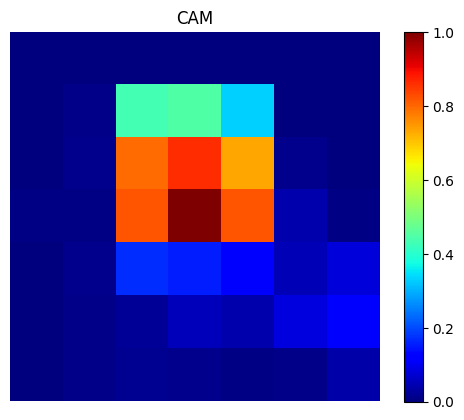

In [21]:
visualize_cam(cam)

In [22]:
def visualize_cam_on_image(cam, img, alpha=0.5):
    # CAM 크기를 원본 이미지 크기로 조정
    cam_resized = cv2.resize(cam, (img.shape[1], img.shape[0]))

    # CAM을 컬러 heatmap으로 변환 (cv2.applyColorMap는 BGR로 반환하므로 RGB로 변경)
    heatmap = cv2.applyColorMap(np.uint8(255 * cam_resized), cv2.COLORMAP_JET)
    heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)

    # 원본 이미지와 heatmap을 alpha blending
    overlay = heatmap * alpha + img * (1 - alpha)
    overlay = overlay.astype(np.uint8)

    plt.figure(figsize=(8,8))
    plt.imshow(overlay)
    plt.title("CAM Overlay on Image")
    plt.axis('off')
    plt.show()

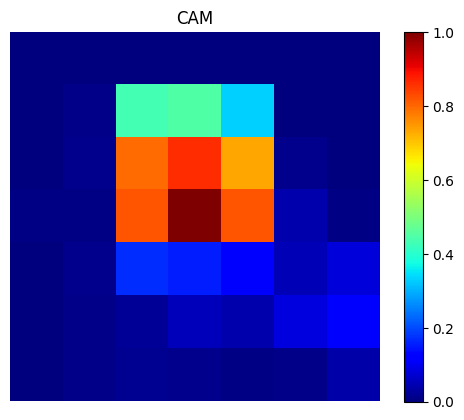

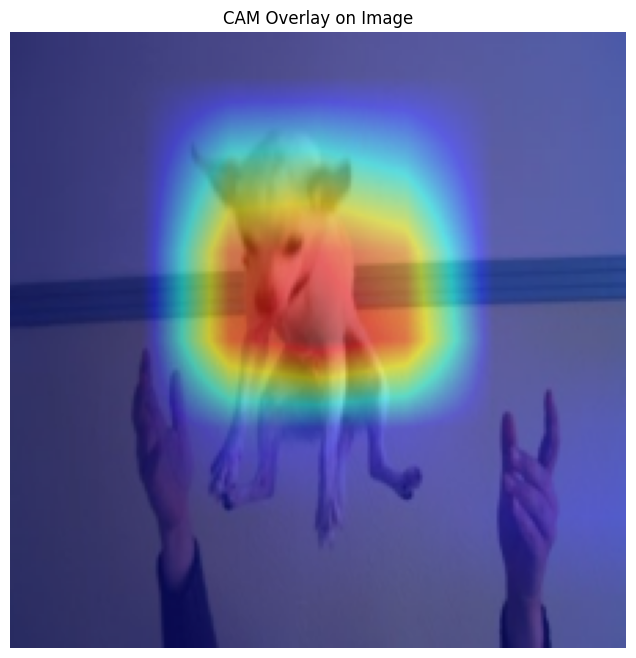

In [23]:
# 원본 이미지 복원
orig_img = unnormalize(image)

# CAM 단독 시각화
visualize_cam(cam)

# 원본 이미지 위에 CAM overlay 시각화
visualize_cam_on_image(cam, orig_img)

## **Grad-CAM 구현하기**

In [24]:
def generate_grad_cam(model, image, target_layer_name):
    model.eval()
    features = {}
    gradients = {}

    # forward hook: 대상 레이어의 출력을 저장
    def forward_hook(module, input, output):
        features['value'] = output.detach()

    # backward hook: 대상 레이어의 gradient를 저장
    def backward_hook(module, grad_in, grad_out):
        gradients['value'] = grad_out[0].detach()

    # 모델 내에서 이름이 target_layer_name과 일치하는 레이어 검색
    target_layer = dict(model.named_modules()).get(target_layer_name, None)
    if target_layer is None:
        raise ValueError(f"Layer '{target_layer_name}' not found in the model.")

    # hook 등록
    forward_handle = target_layer.register_forward_hook(forward_hook)
    backward_handle = target_layer.register_backward_hook(backward_hook)

    # 순전파 실행
    output = model(image)
    pred_class = output.argmax(dim=1).item()

    # 예측 클래스에 대해 backward 수행
    model.zero_grad()
    score = output[0, pred_class]
    score.backward()

    # hook 제거
    forward_handle.remove()
    backward_handle.remove()

    # 저장된 feature map과 gradient 추출 (shape: [C, H, W])
    fmap = features['value'][0]
    grads = gradients['value'][0]

    # 각 채널에 대해 gradient의 global average pooling 계산 (weight 역할)
    weights = torch.mean(grads, dim=(1, 2))

    # weighted sum: 각 채널의 feature map에 weight를 곱해 합산
    grad_cam = torch.zeros(fmap.shape[1:], dtype=torch.float32, device=fmap.device)
    for i, w in enumerate(weights):
        grad_cam += w * fmap[i, :, :]
    grad_cam = grad_cam.cpu().numpy()

    # ReLU 적용 및 정규화: 음수 값 제거 및 [0,1] 범위로 스케일링
    grad_cam = np.maximum(grad_cam, 0)
    grad_cam = (grad_cam - grad_cam.min()) / (grad_cam.max() - grad_cam.min() + 1e-8)

    return grad_cam

In [25]:
# 모델을 불러오세요

# [[YOUR CODE]]
model = torch.load(cam_model_path, weights_only=False)

/home/jjeong3150/anaconda3/envs/aiffel_learning_py312/lib/python3.12/site-packages/torch/nn/modules/module.py:1867: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


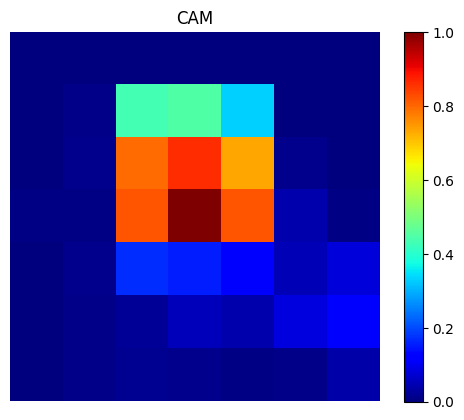

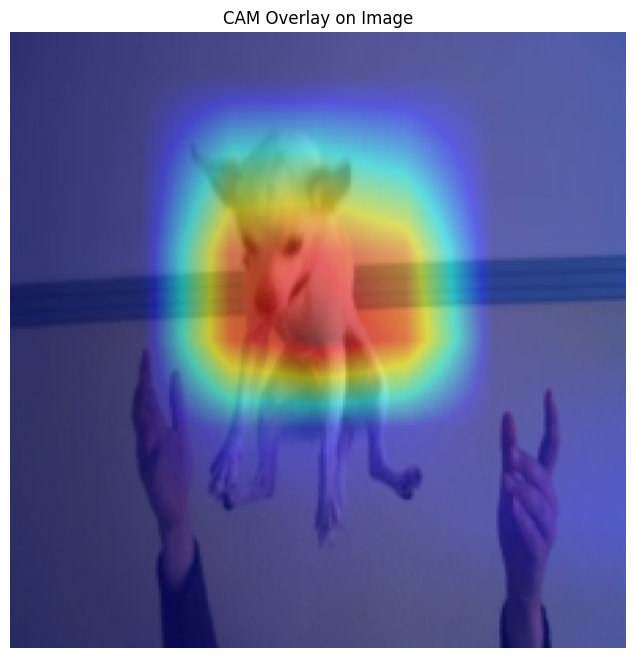

In [26]:
# layer4 사용
grad_cam = generate_grad_cam(model, sample_image, target_layer_name="layer4")

# Grad-CAM 단독 시각화
visualize_cam(grad_cam)

# 전처리된 이미지를 원본 이미지로 복원 후 overlay 시각화
orig_img = unnormalize(image)
visualize_cam_on_image(grad_cam, orig_img)

## Detection with CAM

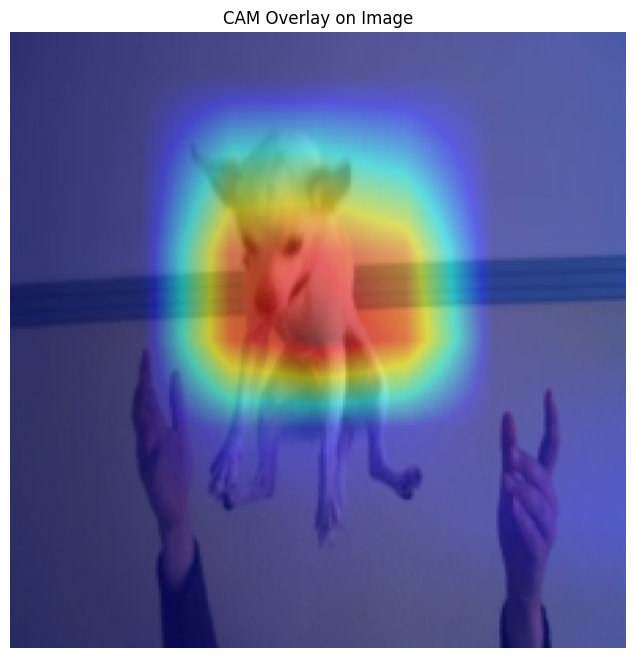

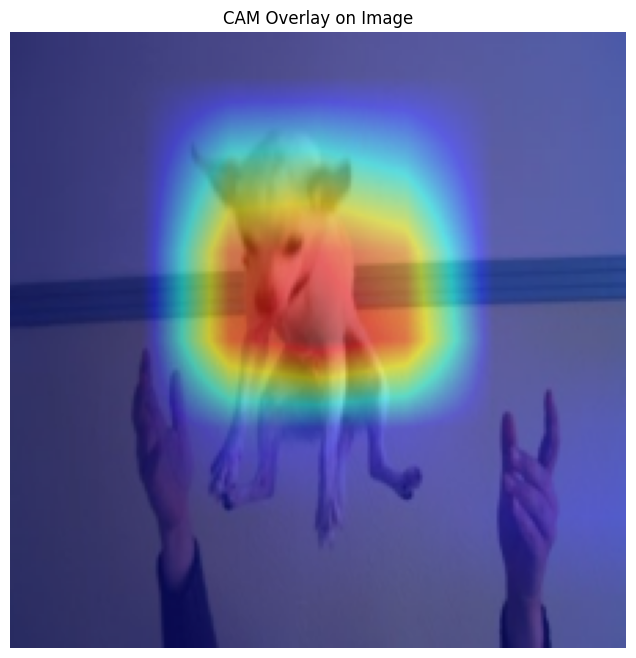

In [27]:
image, label, ground_bbox = train_dataset[0]
sample_image = image.unsqueeze(0).to(device)
orig_img = unnormalize(image)
grad_cam = generate_grad_cam(model, sample_image, target_layer_name="layer4")

visualize_cam_on_image(grad_cam, orig_img)
visualize_cam_on_image(cam, orig_img)

In [28]:
def get_bbox(cam, threshold=0.01):
    coords = np.argwhere(cam > threshold)
    if coords.size == 0:
        return None
    # np.argwhere의 결과는 (row, col) 즉, (y, x) 순서입니다.
    y_min, x_min = coords.min(axis=0)
    y_max, x_max = coords.max(axis=0)
    return (x_min, y_min, x_max, y_max)

In [29]:
cam_resized = cv2.resize(cam, (orig_img.shape[1], orig_img.shape[0]))
grad_cam_resized = cv2.resize(grad_cam, (orig_img.shape[1], orig_img.shape[0]))

cam_bbox = get_bbox(cam_resized, threshold=0.5)
grad_cam_bbox = get_bbox(grad_cam_resized, threshold=0.5)
print(cam_bbox)
print(grad_cam_bbox)

(np.int64(67), np.int64(52), np.int64(156), np.int64(130))
(np.int64(67), np.int64(52), np.int64(156), np.int64(130))


In [30]:
def visualize_bbox_on_image(img, bbox, box_color=(255, 0, 0), thickness=2):
    # 원본 이미지 복사
    img_with_bbox = img.copy()
    if bbox is not None:
        x_min, y_min, x_max, y_max = bbox
        cv2.rectangle(img_with_bbox, (x_min, y_min), (x_max, y_max), box_color, thickness)
    else:
        print("활성화된 영역이 없습니다.")
    return img_with_bbox

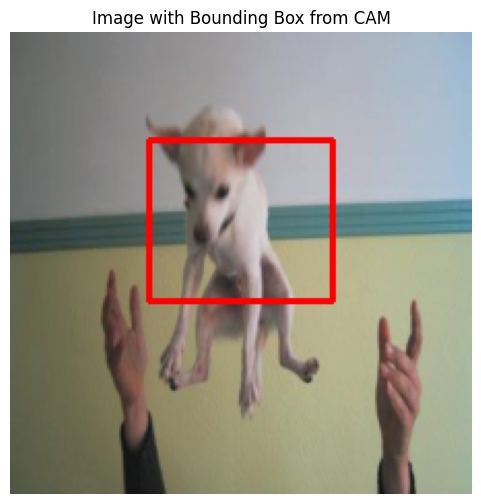

In [31]:
img_cam_bbox = visualize_bbox_on_image(orig_img, cam_bbox)

plt.figure(figsize=(6,6))
plt.imshow(img_cam_bbox)
plt.title("Image with Bounding Box from CAM")
plt.axis("off")
plt.show()

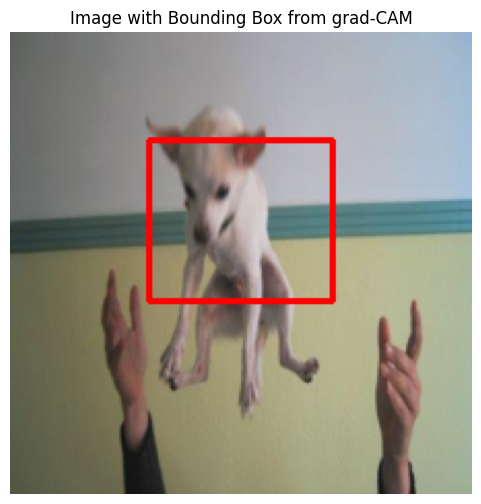

In [32]:
img_grad_cam_bbox = visualize_bbox_on_image(orig_img, grad_cam_bbox)

plt.figure(figsize=(6,6))
plt.imshow(img_grad_cam_bbox)
plt.title("Image with Bounding Box from grad-CAM")
plt.axis("off")
plt.show()

In [33]:
ground_bbox

[63.616, 32.32214765100671, 150.08, 187.91946308724832]

In [34]:
def get_iou(bbox1, bbox2):
    # bbox 중 하나라도 None이면 IoU 0.0
    if bbox1 is None or bbox2 is None:
        return 0.0

    x_min1, y_min1, x_max1, y_max1 = bbox1
    x_min2, y_min2, x_max2, y_max2 = bbox2

    # 두 bbox의 교집합 영역 좌표 계산
    x_min_inter = max(x_min1, x_min2)
    y_min_inter = max(y_min1, y_min2)
    x_max_inter = min(x_max1, x_max2)
    y_max_inter = min(y_max1, y_max2)

    # 교집합의 너비와 높이 (음수가 되지 않도록)
    inter_width = max(0, x_max_inter - x_min_inter)
    inter_height = max(0, y_max_inter - y_min_inter)
    inter_area = inter_width * inter_height

    # 각 bbox의 면적 계산
    area1 = (x_max1 - x_min1) * (y_max1 - y_min1)
    area2 = (x_max2 - x_min2) * (y_max2 - y_min2)

    # 합집합 면적: A ∪ B = A + B - A ∩ B
    union_area = area1 + area2 - inter_area
    if union_area <= 0:
        return 0.0

    iou = inter_area / union_area
    return iou

In [35]:
get_iou(cam_bbox, ground_bbox)

np.float64(0.4656908410720267)

In [36]:
get_iou(grad_cam_bbox, ground_bbox)

np.float64(0.4656908410720267)

In [37]:
def visualize_both_bbox_on_image(img, bbox, ground_truth, thickness=2):
    # 원본 이미지 복사
    img_with_bbox = img.copy()

    x_min, y_min, x_max, y_max = bbox
    cv2.rectangle(img_with_bbox, (x_min, y_min), (x_max, y_max), (255, 0, 0), thickness)

    x_min_t, y_min_t, x_max_t, y_max_t = ground_truth
    cv2.rectangle(img_with_bbox, (x_min_t, y_min_t), (x_max_t, y_max_t), (0, 255, 0), thickness)

    return img_with_bbox

ground_truth = [int(x) for x in ground_bbox]

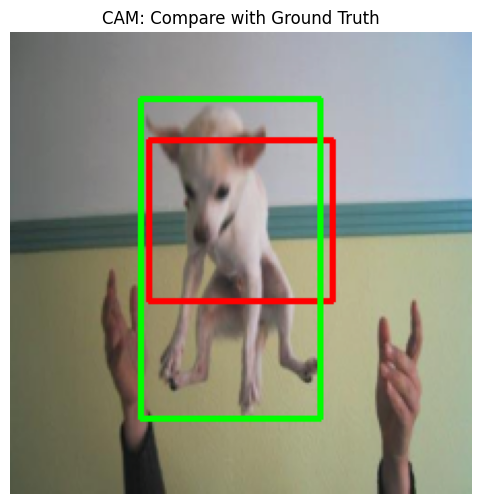

In [38]:
img_bbox = visualize_both_bbox_on_image(orig_img, cam_bbox, ground_truth)

plt.figure(figsize=(6,6))
plt.imshow(img_bbox)
plt.title("CAM: Compare with Ground Truth")
plt.axis("off")
plt.show()

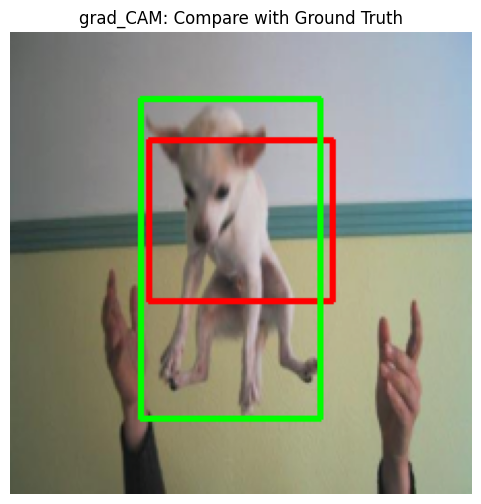

In [39]:
img_bbox = visualize_both_bbox_on_image(orig_img, grad_cam_bbox, ground_truth)

plt.figure(figsize=(6,6))
plt.imshow(img_bbox)
plt.title("grad_CAM: Compare with Ground Truth")
plt.axis("off")
plt.show()

# **중간고찰**

### **이 실험의 목적?**
- CAM, gard-CAM을 활용하여 Bounding BOX를 추출하고 IOU를 높여보기 

### **결과**
- **CAM의 IOU : 0.5045786637069882**
- **grad-CAM의 IOU : 0.5045786637069882**

### **CAM과 grad-CAM의 IOU가 같게 나오는 이유?** ###
- feature map, feature map에 곱하는 weight까지 같기 때문
- CAM과 Grad-CAM은 상수배 차이밖에 나지 않음
- CAM 수식  
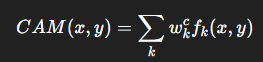
- Grad-CAM 수식  
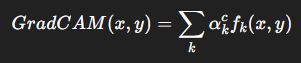
- gradient 평균  
  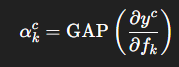
  - GAP 수식  
    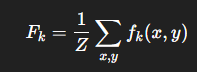
  - FC layer 계산  
    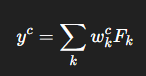  
    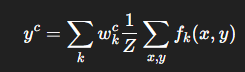 
    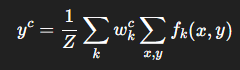
  - y^c를 f_k(x,y)로 미분  
    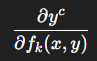
    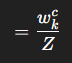
  - GAP 적용  
    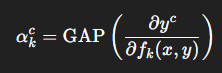  
    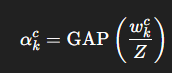

### **결론**  
- 상수 1/Z만 차이
- CAM과 Grad-CAM의 normalize하면 완전히 동일하게 됨
- 사실상 4 layer의 IOU만 비교하는 건 크게 의미가 없을듯
- 단순히 CAM과 Grad-CAM 사이의 비교가 아니라... CNN이 어떤 수준의 정보를 어디서 표현하는지 보는 실험이 아닐까?



- 현황파악
  - 전체 데이터에 대한 평균 IOU 구해보기
  - 샘플 구해보기
- 추가 실험
  - 가정1. Grad-CAM의 3layer에서는 타겟 사물의 전체적인 부분을 살펴보기 때문에 IOU를 계산하면 더 성능이 높을 것이다 
  - 가정2. 

# **추가 실험을 위한 현황 파악**

In [40]:
def visualize_multiple_cams(cams, img, alpha=0.5):
    """
    cams: CAM numpy 배열 리스트 (길이 4 가정)
    img: 원본 이미지 (H,W,3)
    """

    n = len(cams)

    plt.figure(figsize=(16,4))

    for i, cam in enumerate(cams):
        # CAM 크기 → 이미지 크기 맞춤
        cam_resized = cv2.resize(cam, (img.shape[1], img.shape[0]))

        # heatmap 생성
        heatmap = cv2.applyColorMap(
            np.uint8(255 * cam_resized),
            cv2.COLORMAP_JET
        )
        heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)

        # overlay
        overlay = heatmap * alpha + img * (1 - alpha)
        overlay = overlay.astype(np.uint8)

        # subplot
        plt.subplot(1, n, i+1)
        plt.imshow(overlay)
        plt.title(f"layer {i+1}")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

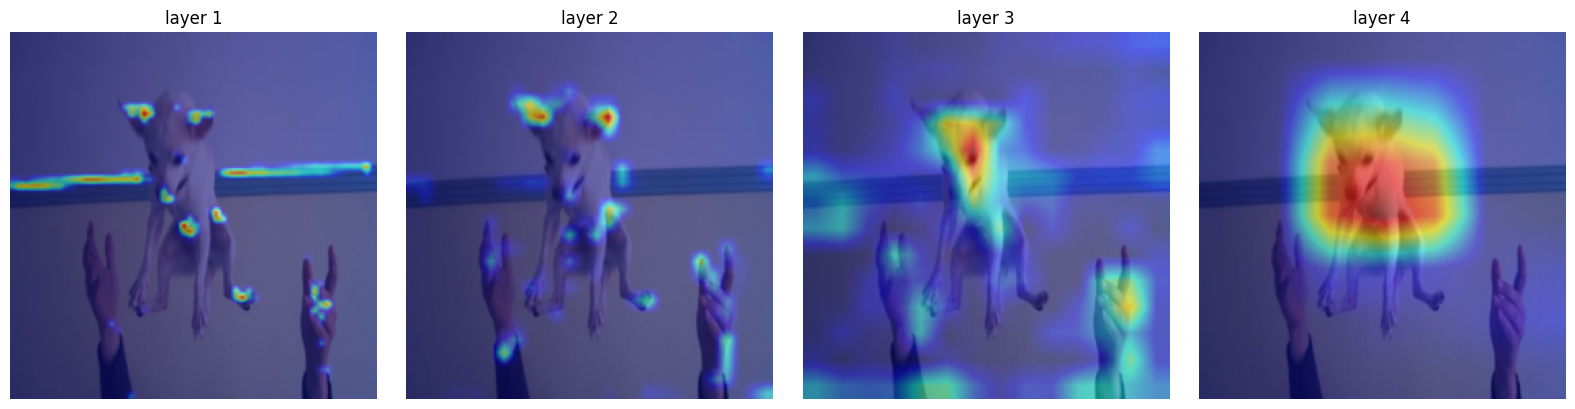

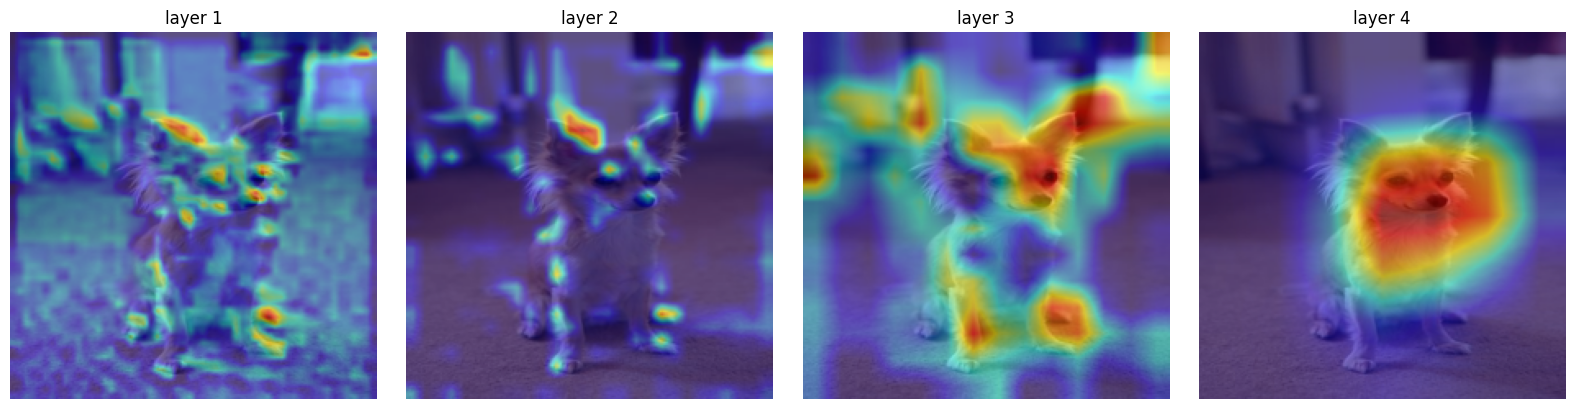

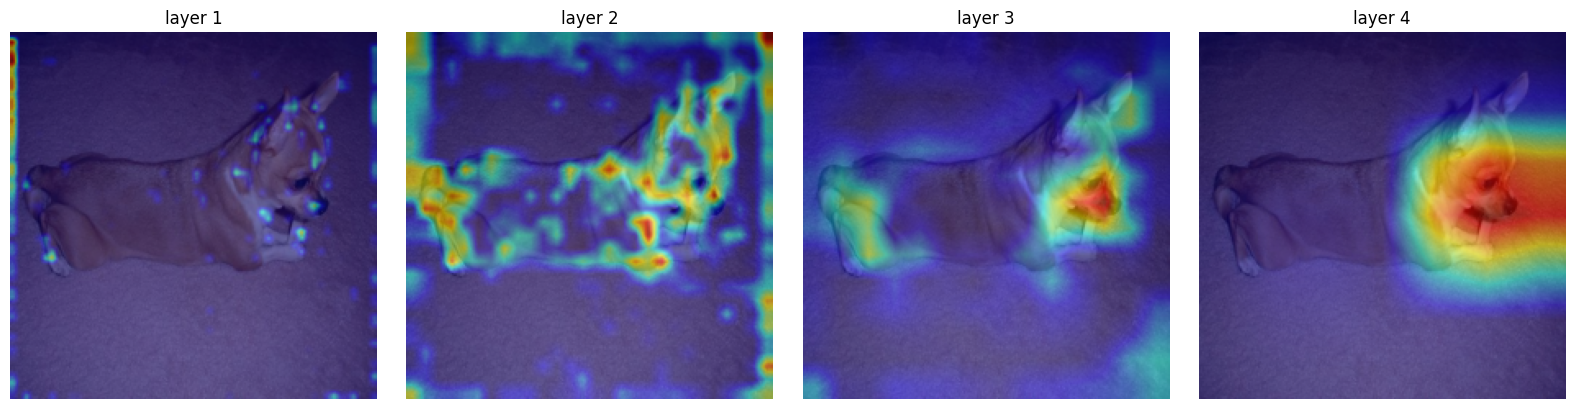

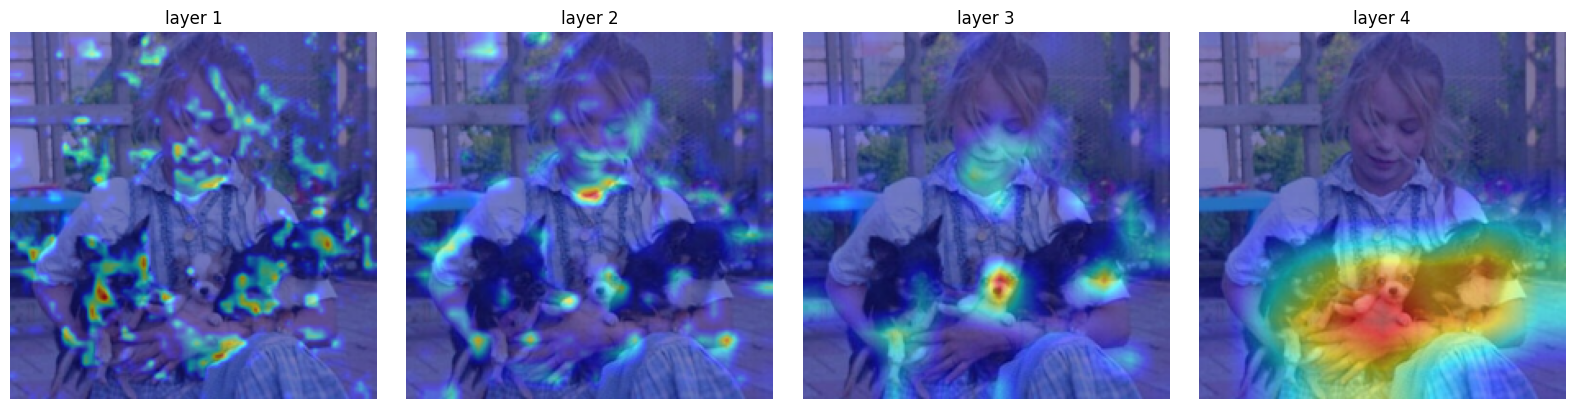

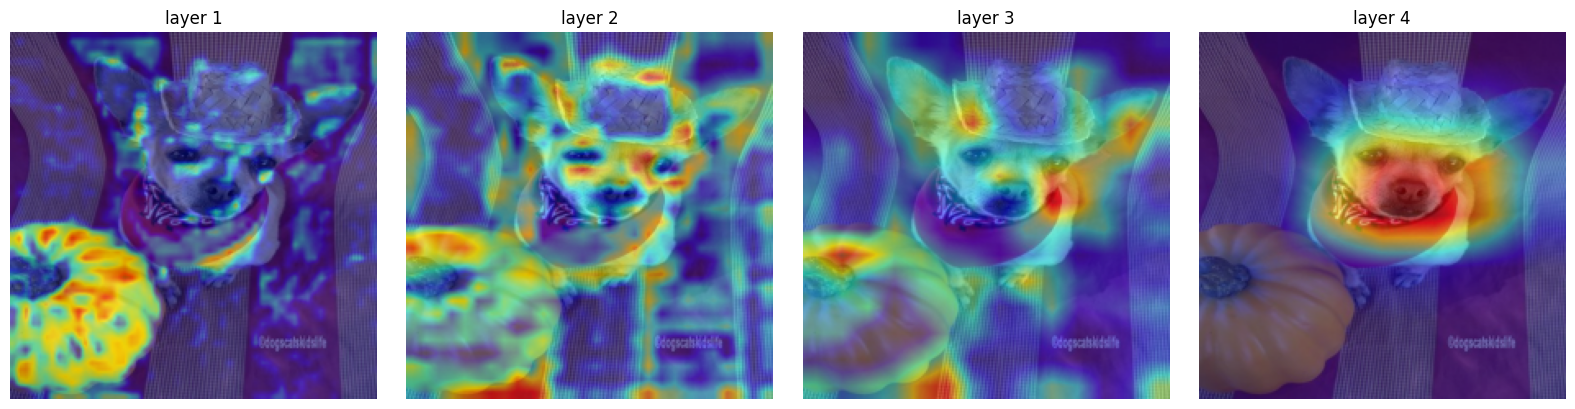

In [41]:
# 5개 이미지 확인

for i in range(5):
    image, label, bbox = train_dataset[i]
    sample_image = image.unsqueeze(0).to(device)
    orig_img = unnormalize(image)
    grad_cam_ly1 = generate_grad_cam(model, sample_image, target_layer_name="layer1")
    grad_cam_ly2 = generate_grad_cam(model, sample_image, target_layer_name="layer2")
    grad_cam_ly3 = generate_grad_cam(model, sample_image, target_layer_name="layer3")
    grad_cam_ly4 = generate_grad_cam(model, sample_image, target_layer_name="layer4")

    grad_cams = [grad_cam_ly1, grad_cam_ly2, grad_cam_ly3, grad_cam_ly4]

    visualize_multiple_cams(grad_cams, orig_img)

In [44]:
# 전체 데이터에 대한 IOU를 구하기에는 시간이 오래걸려, 100장으로 방향성 잡기로 함

import numpy as np
import torch
import random

def set_seed(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

set_seed(42)

N = len(train_dataset)
k = 100

# ✅ 중복 없이 랜덤 샘플링
sample_indices = np.random.choice(N, size=k, replace=False)

iou_list = []

for i in sample_indices:
    image, label, bbox = train_dataset[i]
    sample_image = image.unsqueeze(0).to(device)
    orig_img = unnormalize(image)
    grad_cam_ly4 = generate_grad_cam(model, sample_image, target_layer_name="layer4")

    cam_resized = cv2.resize(grad_cam_ly4, (orig_img.shape[1], orig_img.shape[0]))
    cam_bbox = get_bbox(cam_resized, threshold=0.5)

    iou_list.append(get_iou(cam_bbox, bbox))

print("100개 데이터에 대한 평균 IOU: ", np.mean(iou_list))

100개 데이터에 대한 평균 IOU:  0.3136593463183068


## 현황 정리
- validation의 정확도가 81.92로 대체적으로 분류는 잘하는 것 같음
- IOU도 0.5정도로 보통의 수준을 보여줌
- 개의 머리부분에 수렴하는 경향이 있음
- 개의 몸통은 무시하는 편인듯
- Grad-CAM으로 1 ~ 3-layer의 CAM도 추출해보니, 3-layer의 경우 개의 몸통 전체를 인식하는 것으로 보임

## 문제점?
- 대체적으로 IOU가 0.5정도면 나쁘지 않음
- 그러나 개의 몸통을 잘 인지 못하는 경향이 있음
- 이를 해결하면 IOU 인식률을 더 높일 수 있을 것으로 예상함

## 추가 실험
- 실험1
  - 가정: Grad-CAM의 3-layer에서는 타겟 사물의 전체적인 부분을 살펴보기 때문에 3-layer로 BBOX를 생성하여 IOU를 계산하면 더 성능이 높을 것이다
- 실험2
  - 가정: Grad-CAM의 3-layer는 몸통에 학습이 분산되는 것으로 보아 3-layer와 4-layer의 가중치를 일정비율로 더하여 Heatmap을 구하고, IOU를 구하면 성능이 더 좋아질 것이다

## **실험1**

In [59]:
# 전체 데이터에 대한 IOU를 구하기에는 시간이 오래걸려, 100장으로 방향성 잡기로 함

import numpy as np
import torch
import random

iou_list = []

for i in sample_indices:
    image, label, bbox = train_dataset[i]
    sample_image = image.unsqueeze(0).to(device)
    orig_img = unnormalize(image)

    # 3-layer로 변경해보기
    grad_cam_ly3 = generate_grad_cam(model, sample_image, target_layer_name="layer3")

    cam_resized = cv2.resize(grad_cam_ly3, (orig_img.shape[1], orig_img.shape[0]))
    cam_bbox = get_bbox(cam_resized, threshold=0.5)

    iou_list.append(get_iou(cam_bbox, bbox))

print("100개 데이터에 대한 평균 IOU: ", np.mean(iou_list))

100개 데이터에 대한 평균 IOU:  0.5296634576671942


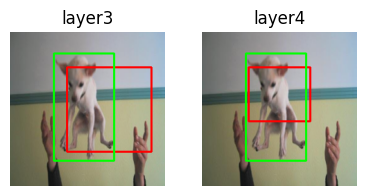

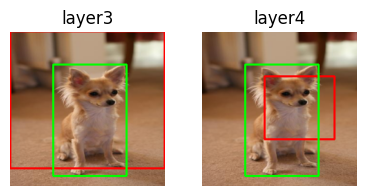

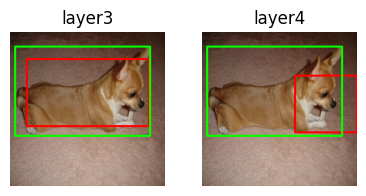

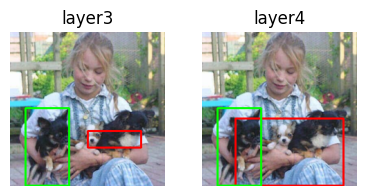

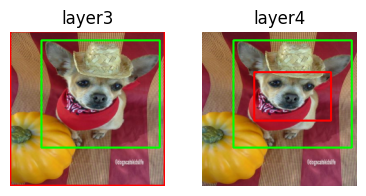

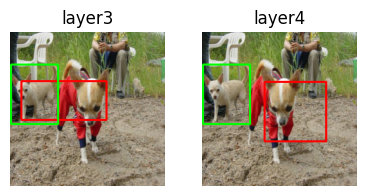

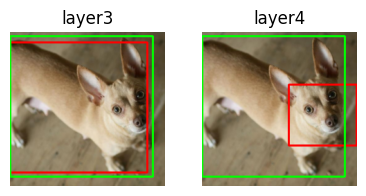

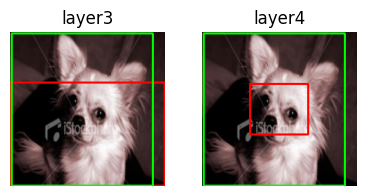

In [61]:
import matplotlib.pyplot as plt
import cv2
import numpy as np

for i in range(8):
    image, label, bbox = train_dataset[i]
    sample_image = image.unsqueeze(0).to(device)
    orig_img = unnormalize(image)

    gt_bbox = [int(x) for x in bbox]
    grad_cam_ly3 = generate_grad_cam(model, sample_image, target_layer_name="layer3")
    grad_cam_ly4 = generate_grad_cam(model, sample_image, target_layer_name="layer4")

    H, W = orig_img.shape[0], orig_img.shape[1]

    cam3_bbox = get_bbox(cv2.resize(grad_cam_ly3, (W, H)), threshold=0.5)
    cam4_bbox = get_bbox(cv2.resize(grad_cam_ly4, (W, H)), threshold=0.5)

    img_l3 = visualize_both_bbox_on_image(orig_img, cam3_bbox, gt_bbox)
    img_l4 = visualize_both_bbox_on_image(orig_img, cam4_bbox, gt_bbox)

    plt.figure(figsize=(4, 2))

    plt.subplot(1, 2, 1)
    plt.imshow(img_l3)
    plt.title(f"layer3")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(img_l4)
    plt.title(f"layer4")
    plt.axis("off")

    plt.tight_layout()
    plt.show()

### 실험1 해석
- 평균 IOU는 크게 상승함(0.31 → 0.53)
- 몇몇 이미지는 개의 몸통까지 잘 잡으나, 몸통이 아닌 다른 부분도 인식되는 경우 배경 전체가 인식되는 경우가 있음
- 과연 BBOX 인식이 잘 됐다고 말할 수 있는지 의심이됨...
- 개가 두 마리 이상이 있는 경우는 라벨이 한 마리만 돼 있어서 틀리게 되는 경우도 생길듯

## **실험2**

In [63]:
import numpy as np
import cv2

def generate_multi_layer_grad_cam(
    model,
    image,
    target_layer_names,   # 예: ["layer3", "layer4"]
    weights=None,         # 예: [0.4, 0.6] (None이면 균등)
    merge="sum"           # "sum" 또는 "max"
):
    """
    model: nn.Module
    image: torch.Tensor, shape [1,3,H,W]
    target_layer_names: list[str]
    weights: list[float] or None
    merge: "sum" or "max"
    return: combined_cam (numpy, 0~1)
    """

    cams = []
    for layer_name in target_layer_names:
        cam = generate_grad_cam(model, image, layer_name)  # 네 함수 그대로 사용
        cams.append(cam)

    # weights 기본값: 균등
    n = len(cams)
    if weights is None:
        weights = [1.0 / n] * n
    else:
        if len(weights) != n:
            raise ValueError("weights 길이는 target_layer_names 길이와 같아야 합니다.")
        # 합이 1이 아니어도 되지만, 보통 안정성을 위해 정규화
        s = sum(weights)
        weights = [w / (s + 1e-8) for w in weights]

    # 크기 통일: 첫 번째 CAM 크기에 맞춤
    base_h, base_w = cams[0].shape
    cams_resized = []
    for cam in cams:
        if cam.shape != (base_h, base_w):
            cam = cv2.resize(cam, (base_w, base_h), interpolation=cv2.INTER_LINEAR)
        cams_resized.append(cam)

    # 결합
    if merge == "sum":
        combined = np.zeros((base_h, base_w), dtype=np.float32)
        for w, cam in zip(weights, cams_resized):
            combined += float(w) * cam

    elif merge == "max":
        combined = cams_resized[0].astype(np.float32)
        for cam in cams_resized[1:]:
            combined = np.maximum(combined, cam.astype(np.float32))

    else:
        raise ValueError("merge는 'sum' 또는 'max'만 지원합니다.")

    # 최종 정규화
    combined = np.maximum(combined, 0)
    combined = (combined - combined.min()) / (combined.max() - combined.min() + 1e-8)

    return combined

In [78]:
# 전체 데이터에 대한 IOU를 구하기에는 시간이 오래걸려, 100장으로 방향성 잡기로 함

import numpy as np
import torch
import random

iou_list = []

for i in sample_indices:
    image, label, bbox = train_dataset[i]
    sample_image = image.unsqueeze(0).to(device)
    orig_img = unnormalize(image)

    # 3-layer로 변경해보기
    grad_cam_ly34 = generate_multi_layer_grad_cam(model, sample_image, target_layer_names=["layer3", "layer4"], weights=[0.5, 0.5], merge="sum")

    cam_resized = cv2.resize(grad_cam_ly34, (orig_img.shape[1], orig_img.shape[0]))
    cam_bbox = get_bbox(cam_resized, threshold=0.5)

    iou_list.append(get_iou(cam_bbox, bbox))

print("100개 데이터에 대한 평균 IOU: ", np.mean(iou_list))

100개 데이터에 대한 평균 IOU:  0.4664987507080043


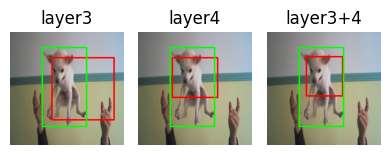

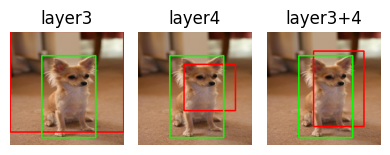

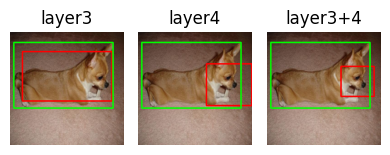

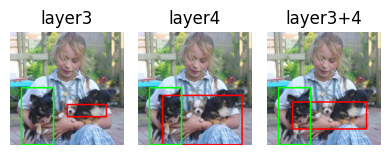

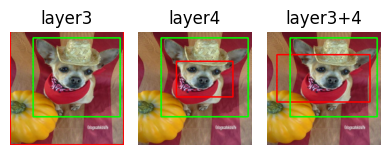

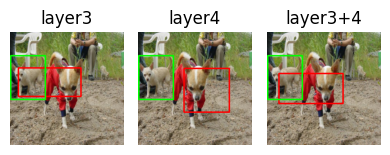

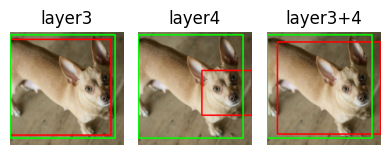

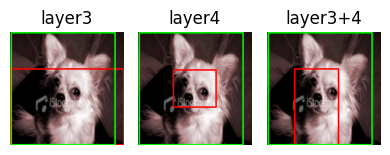

In [79]:
import matplotlib.pyplot as plt
import cv2
import numpy as np

for i in range(8):
    image, label, bbox = train_dataset[i]
    sample_image = image.unsqueeze(0).to(device)
    orig_img = unnormalize(image)

    gt_bbox = [int(x) for x in bbox]
    grad_cam_ly3 = generate_grad_cam(model, sample_image, target_layer_name="layer3")
    grad_cam_ly4 = generate_grad_cam(model, sample_image, target_layer_name="layer4")
    grad_cam_ly34 = generate_multi_layer_grad_cam(model, sample_image, target_layer_names=["layer3", "layer4"], weights=[0.5, 0.5], merge="sum")

    H, W = orig_img.shape[0], orig_img.shape[1]

    cam3_bbox = get_bbox(cv2.resize(grad_cam_ly3, (W, H)), threshold=0.5)
    cam4_bbox = get_bbox(cv2.resize(grad_cam_ly4, (W, H)), threshold=0.5)
    cam34_bbox = get_bbox(cv2.resize(grad_cam_ly34, (W, H)), threshold=0.5)
    
    img_l3 = visualize_both_bbox_on_image(orig_img, cam3_bbox, gt_bbox)
    img_l4 = visualize_both_bbox_on_image(orig_img, cam4_bbox, gt_bbox)
    img_l34 = visualize_both_bbox_on_image(orig_img, cam34_bbox, gt_bbox)
    
    plt.figure(figsize=(4, 2))

    plt.subplot(1, 3, 1)
    plt.imshow(img_l3)
    plt.title(f"layer3")
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.imshow(img_l4)
    plt.title(f"layer4")
    plt.axis("off")

    plt.subplot(1, 3, 3)
    plt.imshow(img_l34)
    plt.title(f"layer3+4")
    plt.axis("off")

    plt.tight_layout()
    plt.show()

### 실험2 해석
- 평균 IOU는 실험1보다 좀 줄었음(0.53 → 0.46)
- IOU가 작아지긴 했지만, 좀 더 안정적으로 BBOX를 뽑을 수 있지 않을까 싶음
- 무작정 전체 이미지를 BBOX를 생성하는 문제는 완화시킬 수 있을 것 같음

## **최종 회고**
- Grad-CAM을 통해 layer 별로 이미지 데이터 각 부분의 중요도가 다름을 알 수 있었음
- BBOX 생성 시 최종 layer뿐만이 아니라 목적에 따라 다른 layer의 CAM을 활용할 수 있을 것 같음
- 배경이 인식되는 경우가 많은 것 같아서, 학습 시에 배경에 대한 bias를 제거하는 augmentation을 진행하면 배경을 인식하는 경우가 해결될 수도 있을 것 같음